# Uvoz podatkov

Podatki iz 5. 11. 2019

Najprej poskrbimo za uvozi podatkov in potrebnih knjižnic.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import math

players = pd.read_csv('csv/overallFIXED.csv', index_col='Id', encoding='utf8')
general = pd.read_csv('csv/general.csv', index_col='Id')
solo = pd.read_csv('csv/solo.csv', index_col='Id')
duo = pd.read_csv('csv/duo.csv', index_col='Id')
triple = pd.read_csv('csv/triple.csv', index_col='Id')
quad = pd.read_csv('csv/quad.csv', index_col='Id')

pd.options.display.max_rows = 50
%matplotlib inline

# Nekaj o igri Bedwars

Igra se dogaja med več skupinami igralcev. V Solo načinu je to $12$ posameznikov, v Duo $12$ skupin po dva, v Triple štiri skupine po tri in v Quad štiri skupine po štiri. Cilj igre je uničiti posteljo (zato bedwars t.j. vojne postelj) od nasprotnih skupin (dokler postelja obsataja imajo igralci neskončno življenj) in po uničenju postelje ubiti nasprotnike. Vsak tak uboj šteje kot končni uboj (final kill oz. FK). Če dosežemo, da so vsi nasprotni igralci končno mrtvi je to za nas zmaga. Če mi končno umremo (final death oz. FD) to še ne pomeni nujno poraza, saj lahko naši soigralci igro še vedno zmagajo, vendar je to bolj redkost kot pravilo (kar lahko vidimo iz spodnjih grafov). Med igro igralci tudi pobirajo različne surovine, ki se pojavljajo na različnih delih arene, s katerimi si lahko kupijo pripomočke, ki jim lajšajo pot do zmage.

In [2]:
((solo['FD']/solo['L']).mean(),
 (duo['FD']/duo['L']).mean(),
 (triple['FD']/triple['L']).mean(),
 (quad['FD']/quad['L']).mean())

(0.8335256089936279, 1.006559142696057, 1.033374843321147, 1.0974619344493741)

Kot opazimo je razmerje med FD in L približno $1$. Nekaj razlike je v Solo načinu, kjer igralci večkrat zapustijo igro, kar tudi šteje kot izguba, ker se v tem načinu ne da ponovno pridružiti igri. Pri Quad pa opazimo, da se največkrat zgodi, da kljub igralčevi končni smrti, igrlec ne izgubi, kar je pričakovati, saj ima v tem načinu največ soigralcev.

# Nekaj o podatkih

Podatke sem zajel s strani plancke.io. Vzel sem $1000$ igralcev z največjim številom zmag v vseh načinih skupno. Opazimo lahko, da imamo le $996$ igralcev ne $1000$. To je zaradi napake na strani plancke.io, ki ima težave s prikazovanjem in naključno spusti nekaj igralcev. 

Za vsakega igralca sem nato zajel njegovo stran na plancke.io, kjer so še vse druge statistike (naprimer količina pobranih surovin, statistike za Solo, Duo, Triple, Quad načine ...). Nato sem te podatke spravil v csv datoteke, s katerimi bomo tukaj delali.

# O povezavi različnih metrik

## Povezava med W/L in FK/D v različnih igralskih načinih

Oglejmo si sedaj najbojl preprost graf. Razmerje med količnikom 'W/L' (Win/Loss oz. Zmaga/Izguba) in 'FK/D' (Final kill/Final death oz. Končnih ubojev/Končnih smrti). Zanima nas ali sta FK/D in W/L v linearni odvistnosti (kar bi pričakovali, saj velja FD ~ L, lahko se zgodi, da naši soigralci vseeno zmagajo vendar to lahko zanemarimo) in če je strmina premice, ki jo dobimo z linearno regresijo kaj različna pri razičnih igralskih načinih. Pomembno je, da se zavedamo, da tukaj gleamo skupni W/L količnik, kar bi lahko interpretirali kot sposobnost igralca.

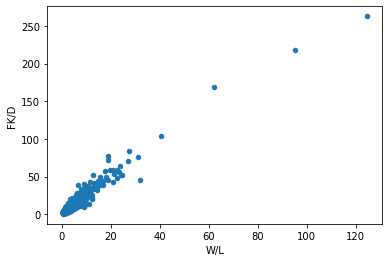

In [3]:
players.plot.scatter('W/L', 'FK/D')

Opazimo lahko, da imajo nekateri igrali izjemno visok količnik W/L. Najverjetneje gre za igralce, ki se trudijo imeti čim več zaporednih zmag. Da bo stvar bolj pregledna bomo nekaj od teh podatkov pobrisali. Izračunajmo do kako majhen je lahko W/L količnik, da še vedno zajamemo vsaj $95\%$ igralcev.

In [4]:
def find_para(column):
    for i in range(math.floor(column.max())):
        if (column[column  < i].count()) / (column.count()) > 0.95:
            return (column[column < i].count(), i)

In [5]:
b = find_para(players['W/L'])
b

(954, 12)

Vidimo, da je $12$ v redu celoštevilski približek. Uporabimo ta približek za naslednji graf, kjer ločimo FK/D količnike glede na igralski način igre (Solo, Duo, Triple, Quad, kar je sam, v paru, v trojicah ali v skupinah po štirih oziroma). Solo igralsi način bo označen z rdečo barvo, Duo z zeleno, Triple z rumeno in Quad s cian modro.

True

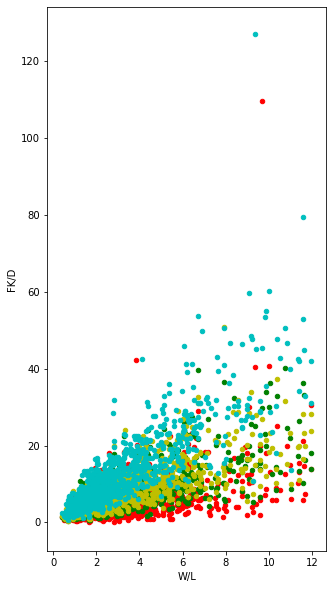

In [6]:
temp = players['W/L']
temp1 = (solo.rename(columns={'FK/D': 'Solo'}))['Solo']
temp2 = (duo.rename(columns={'FK/D': 'Duo'}))['Duo']
temp3 = (triple.rename(columns={'FK/D': 'Triple'}))['Triple']
temp4 = (quad.rename(columns={'FK/D': 'Quad'}))['Quad']
conc = pd.concat([temp, temp1, temp2, temp3, temp4], axis=1)
conc1 = conc[(conc['W/L'] < b[1])]
ax1 = conc1.plot(kind='scatter', x='W/L', y='Solo', color='r')    
ax2 = conc1.plot(kind='scatter', x='W/L', y='Duo', color='g', ax=ax1)    
ax3 = conc1.plot(kind='scatter', x='W/L', y='Triple', color='y', ax=ax1)
ax4 = conc1.plot(kind='scatter', x='W/L', y='Quad', color='c', ax=ax1, figsize=(5,10))
ax4.set_ylabel("FK/D")
ax1 == ax2 == ax3 == ax4

Opazimo lahko, da izgleda kakor, da podatki, glede na barvo, ležijo drug pod drugim. Prav tako opazimo, da nekateri podatki ležijo mnogo višje nad drugimi kot ostali; te podatke bomo izključili iz računov. 

In [7]:
a = max(find_para(conc['Solo'])[1], find_para(conc['Duo'])[1], find_para(conc['Triple'])[1], find_para(conc['Quad'])[1])

True

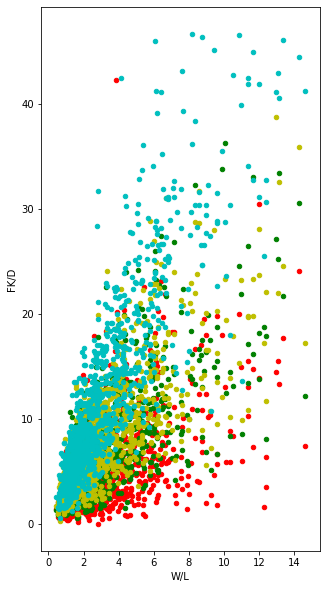

In [8]:
conc1 = conc[(conc['W/L'] < a) & (conc['Solo'] < a) & (conc['Duo'] < a) & (conc['Triple'] < a) & (conc['Quad'] < a)]
ax1 = conc1.plot(kind='scatter', x='W/L', y='Solo', color='r')    
ax2 = conc1.plot(kind='scatter', x='W/L', y='Duo', color='g', ax=ax1)    
ax3 = conc1.plot(kind='scatter', x='W/L', y='Triple', color='y', ax=ax1)
ax4 = conc1.plot(kind='scatter', x='W/L', y='Quad', color='c', ax=ax1, figsize=(5,10))
ax4.set_ylabel("FK/D")
ax1 == ax2 == ax3 == ax4

Izračunajmo s pomočjo linearne regresije (z modulom statsmodels), ali glede na to, iz katerega igralskega načina črpamo podatke, res pride do različnih strmin podatkov. To bomo razbrali iz smrenih koeficientov.

In [9]:
#preimenovanje spremenljivk je potrebno, ker so statmodels šibki
playertemp = players.rename(columns={'FK/D': 'A', 'W/L': 'B'})
playertemp = playertemp[playertemp['B']<b[1]]
conc2 = conc1.rename(columns={'W/L': 'A'})

In [10]:
def lin_reg(rel, data):
    tempdict = sm.ols(formula=rel, data=data).fit()
    return (tempdict.params, tempdict.bse)

In [11]:
#solo
lin_reg("Solo ~ A", conc2)

(Intercept    1.774201
 A            0.962677
 dtype: float64,
 Intercept    0.188166
 A            0.047417
 dtype: float64)

In [12]:
#duo
lin_reg("Duo ~ A", conc2)

(Intercept    1.998761
 A            1.567342
 dtype: float64,
 Intercept    0.195613
 A            0.049293
 dtype: float64)

In [13]:
#triple
lin_reg("Triple ~ A", conc2)

(Intercept    2.526082
 A            1.736329
 dtype: float64,
 Intercept    0.192965
 A            0.048626
 dtype: float64)

In [14]:
#quad
lin_reg("Quad ~ A", conc2)

(Intercept    1.935115
 A            3.218572
 dtype: float64,
 Intercept    0.251345
 A            0.063337
 dtype: float64)

Pri vseh podatkih je napaka (to so števila v spodnjih tabelah, ki pripadajo vrednosti 'A') kvečjemu $0.06$ torej je linearna regresija smiselna. Opazimo lahko tudi, da se koeficienti opazno spreminjajo. V Solo načinu so $1.0$, Duo $1.6$, Triple $1.7$ in Quad $3.2$. 

Torej lahko sklepamo, da, ne glede na W/L količnik, ima igralec največji FK/D količnik v Quad načinu in da je na podatke smiselno gledati kot v linearni odvistnosti.

## O posameznih igralskih načinih

Sedaj si podatke poglejmo še v drugi luči. Poračunajmo razmerje FK/W za posamezne igralske načine. Poglejmo tudi srednjo vrednost W/L.

In [15]:
#solo
(lin_reg("FK ~ W", solo), solo['W/L'].mean())

((Intercept    91.838436
  W             3.958098
  dtype: float64,
  Intercept    12.935369
  W             0.014370
  dtype: float64),
 1.2241365461847389)

In [16]:
#duo
(lin_reg("FK ~ W", duo), duo['W/L'].mean())

((Intercept   -148.808997
  W              4.768134
  dtype: float64,
  Intercept    49.684745
  W             0.032698
  dtype: float64),
 1.9790763052208835)

In [17]:
#triple
(lin_reg("FK ~ W", triple), triple['W/L'].mean())

((Intercept   -69.171065
  W             2.620918
  dtype: float64,
  Intercept    40.987594
  W             0.025221
  dtype: float64),
 4.0195883534136545)

In [18]:
#quad
(lin_reg("FK ~ W", quad), quad['W/L'].mean())

((Intercept    791.588267
  W              2.253396
  dtype: float64,
  Intercept    129.973156
  W              0.030420
  dtype: float64),
 7.158734939759037)

Opazimo lahko, da je linearna regresija ponovno smiselna in da imamo največje razmerje pri Duo igralskem načinu, kar je pričakovano, saj v tem načinu ima igralec največ nasprotnikov (zatem v Solo, Quad in nazadnje v Triple). Preseneti nas lahko, da kljub temu imamo večji koeficient pri Triple kot pri Quad. Preverimo, če je odgovoro mogoče v manjšem številu iger.

In [19]:
(triple['W'] + triple['L']).sum()/(quad['W'] + quad['L']).sum()

0.390562991170596

Verjetno lahko pripišemo vzrok temu, da je v Triple načinu igranih kar $2.5 \times$ iger manj.

# Rezultati glede na guild ali rank na serverju

Tukaj samo preštejemo koliko igralcev na lestvici $1000$ najboljših pripada kateremu guildu oz. ima kateri rank.

In [20]:
guilds = players.groupby('Guild')
guilds.size().reset_index(name='count').sort_values('count', ascending=False).style.hide_index()

Guild,count
None,212
[FAZE],48
[IYN],42
[ANNOY],32
[GGMEN],30
[TRAGEDY],28
[ENIGMA],25
[STORM],23
[DARK],22
[ABYSS],20


In [21]:
rank = players.groupby('Rank')
rank.size().reset_index(name='count').sort_values('count', ascending=False).style.hide_index()

Rank,count
[MVP+],658
[MVP++],226
[VIP],36
None,34
[VIP+],20
[MVP],9
[YOUTUBE],9
[MOD],2
[HELPER],1
[PIG+++],1


# O pogostosti igralskih načinov

## O absolutni pogostosti

Poglejmo si ali je kateri izmed igralskih načinov bolj popularen pri najboljših $1000$ igralcih.

In [22]:
# dodane vrstice - število iger v različnih načinih //100
players.insert(3, "Solo games", (solo.W + solo.L) // 100)
players.insert(4, "Duo games", (duo.W + duo.L) // 100)
players.insert(5, "Triple games", (triple.W + triple.L) // 100)
players.insert(6, "Quad games", (quad.W + quad.L) // 100)

In [23]:
# račun za najmanjšo vrednost ki zajame vsaj 95%
c = max(find_para(players["Solo games"]), find_para(players["Duo games"]), find_para(players["Triple games"]), find_para(players["Quad games"]))
# račun za največje število iger v vseh načinih
d = max(players[["Solo games", "Duo games", "Triple games", "Quad games"]].max())

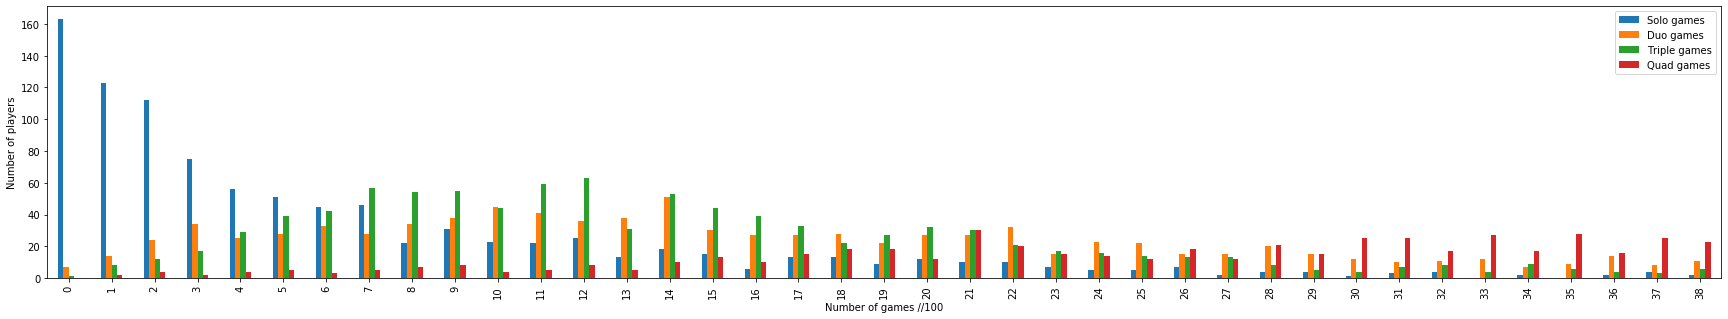

In [24]:
counted_games_temp = pd.DataFrame(data = None, index = [i for i in range(0,d)])
counted_games = pd.concat([counted_games_temp, players["Solo games"].value_counts(), 
players["Duo games"].value_counts(),
players["Triple games"].value_counts(),
players["Quad games"].value_counts()], axis=1)
plot = counted_games.head(c[1]).reset_index().plot.bar(x = 'index', figsize=(30,5))
plot.set_ylabel("Number of players")
plot.set_xlabel("Number of games //100")
plot

Opazimo lahko, da veliko igralcev ne igra oz. igra zelo malo Solo iger. Opazimo tudi, da je več kot $3000$ iger malo igralcev drugje kot v Quad načinu, le nekaj jih je igralo v Duo v Solo ali Triple pa zelo malo.

Oglejmo si še celotno količino igranih iger.

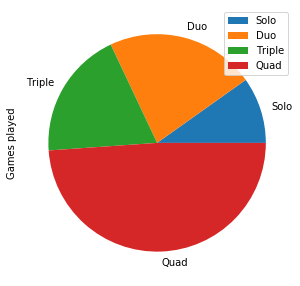

In [25]:
temp = pd.DataFrame({'Games played': [(solo['L']+solo['W']).sum(), (duo['L']+duo['W']).sum() , (triple['L']+triple['W']).sum(), (quad['L']+quad['W']).sum()]}, index = ['Solo', 'Duo', 'Triple', 'Quad'])
plot = temp.plot.pie(y='Games played', figsize=(5, 5))

Opazimo, da je Quad daleč najbolj igran način. Ta graf nam tudi pojsani zakaj je največ Quad in Duo stolpičev v grafu višje.

## O pogostosti relativno na W/L

Sedaj nas bo zanimalo, če tisti igralci z višjim W/L koeficientom, večinsko igrajo katerega od igralskih načinov. Z rdečo označene Solo igre, z zeleno Duo, z rumeno Triple in z cian Quad.

True

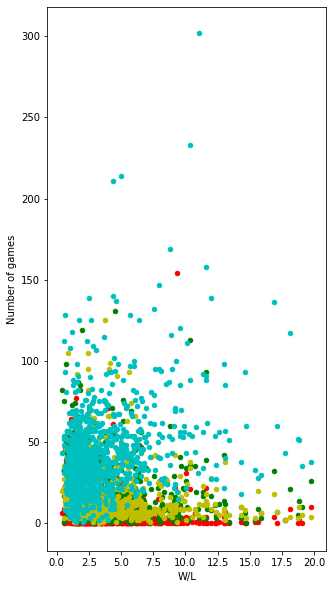

In [26]:
conc1 = players[(players['W/L'] < 20)]
ax1 = conc1.plot(kind='scatter', x='W/L', y='Solo games', color='r')    
ax2 = conc1.plot(kind='scatter', x='W/L', y='Duo games', color='g', ax=ax1)    
ax3 = conc1.plot(kind='scatter', x='W/L', y='Triple games', color='y', ax=ax1)
ax4 = conc1.plot(kind='scatter', x='W/L', y='Quad games', color='c', ax=ax1, figsize=(5,10))
ax4.set_ylabel("Number of games")
ax1 == ax2 == ax3 == ax4

Ne opazimo nobenega posebnega vzorca, razen tega, da se Solo vrednosti pojavljajo kot nizke skozi celoten graf. Poglejmo si grafe posamezno.

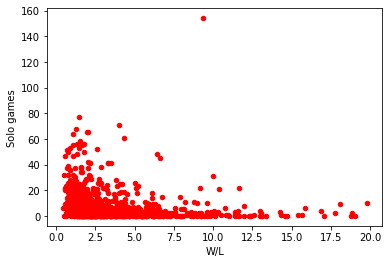

In [27]:
conc1.plot(kind='scatter', x='W/L', y='Solo games', color='r')    

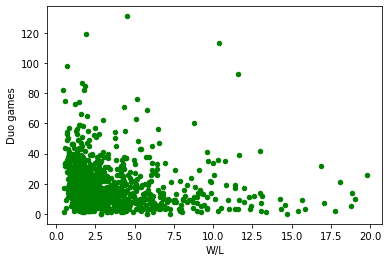

In [28]:
conc1.plot(kind='scatter', x='W/L', y='Duo games', color='g')

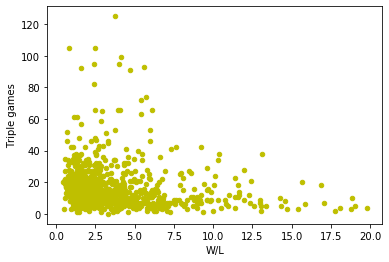

In [29]:
conc1.plot(kind='scatter', x='W/L', y='Triple games', color='y')    

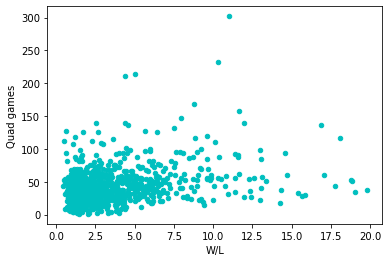

In [30]:
conc1.plot(kind='scatter', x='W/L', y='Quad games', color='c')    

Tudi na posameznih grafih ne opazimo nobene dodatne posebnosti, razen tega, da tisti z visokim W/L koeficientom večinoma igrajo Quad in Triple igre. Pa to preverimo še z enim tortnim diagramom.

In [31]:
e = find_para(players['W/L'])

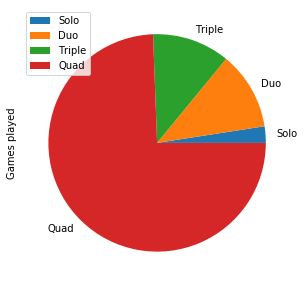

In [32]:
temp = pd.DataFrame({'Games played': [players[players['W/L'] > e[1]]['Solo games'].sum(), players[players['W/L'] > e[1]]['Duo games'].sum(), players[players['W/L'] > e[1]]['Triple games'].sum(), players[players['W/L'] > e[1]]['Quad games'].sum()]}, index = ['Solo', 'Duo', 'Triple', 'Quad'])
plot = temp.plot.pie(y='Games played', figsize=(5, 5))

Opazimo lahko, da igralci z največim $5\%$ W/L koeficientom igrajo še več Quad iger kot večina.

Oglejmo si še, če obstaja kakšna povezava med W/L koeficientom in številom iger

In [33]:
conc1.insert(0, 'Total games', (conc1['Solo games']+conc1['Duo games']+conc1['Triple games']+conc1['Quad games']))

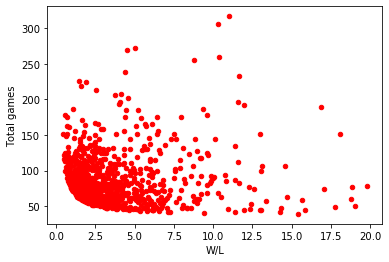

In [34]:
conc1.plot(kind='scatter', x='W/L', y='Total games', color='r')

Izgleda, da ni nobenega vzorca, razen morda tega, da tisti imajo tisti z večjim W/L manj iger. Kar je smiselno, saj naši podatki vsebujejo igralce z velikim številom zmag. Z večjim W/L koeficientom igralec tako potrebuje manj iger.

# Število pobranih surovin

Ponovno nas zanima, če obtaja kakšna povezava s W/L koeficientom in številom pobranih surovin (iron, gold, diamond, emerald t.j. železo, zlato, diamanti, emeraldi oziroma).

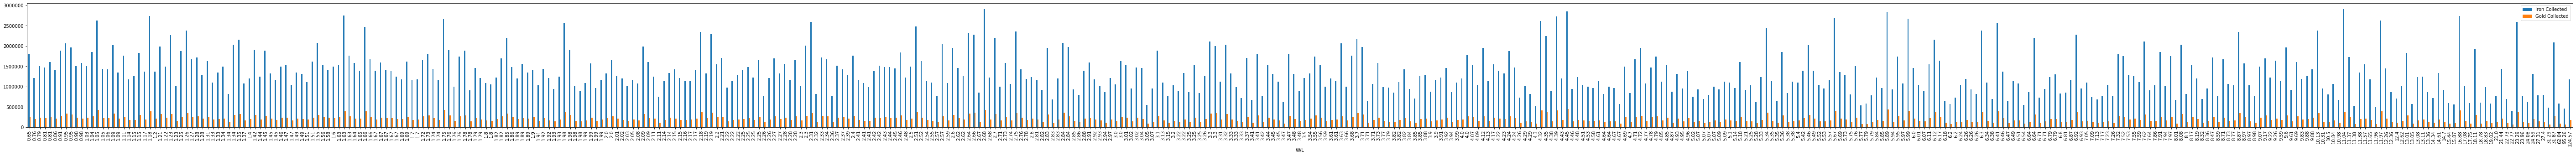

In [35]:
temp = pd.concat([players, general], axis=1)
temp1 = temp[(((temp['Quad games'])/(temp['Solo games']+temp['Duo games']+temp['Triple games']+temp['Quad games'])) > 0.5) &
            (temp['Iron Collected'] < 3000000)]
ax1 = temp1[['W/L','Iron Collected','Gold Collected']].sort_values(by='W/L').plot(kind='bar', x='W/L', figsize=(100,5))

Opazimo, da je tak graf izredno nepregleden zaradi velikosti. Tako, da si raje poglejmo povprečno število pobranih surovin, če W/L zaokrožimo na celo število. Ponovno izključimo vrhnjih $5\%$.

In [36]:
temp['Rounded W/L'] = round(temp['W/L'])

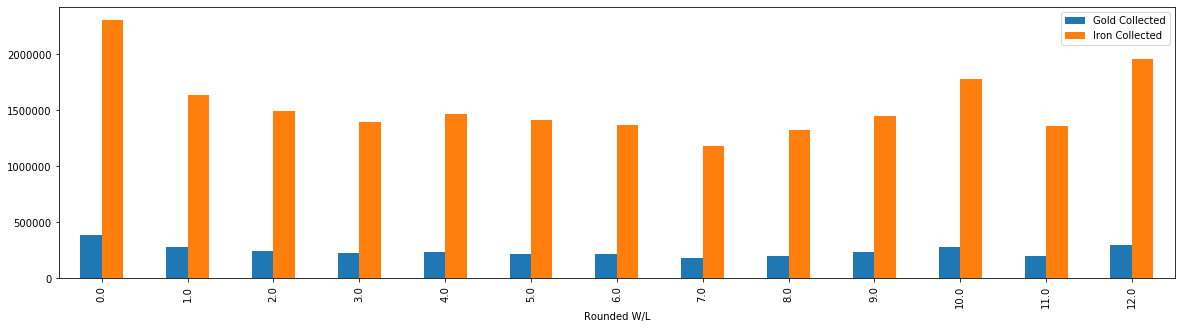

In [37]:
temp = temp[temp['W/L'] < b[1]]
(temp[['Rounded W/L', 'Gold Collected', 'Iron Collected']].groupby(['Rounded W/L']).mean()).reset_index().plot(kind='bar', x='Rounded W/L', figsize=(20,5))

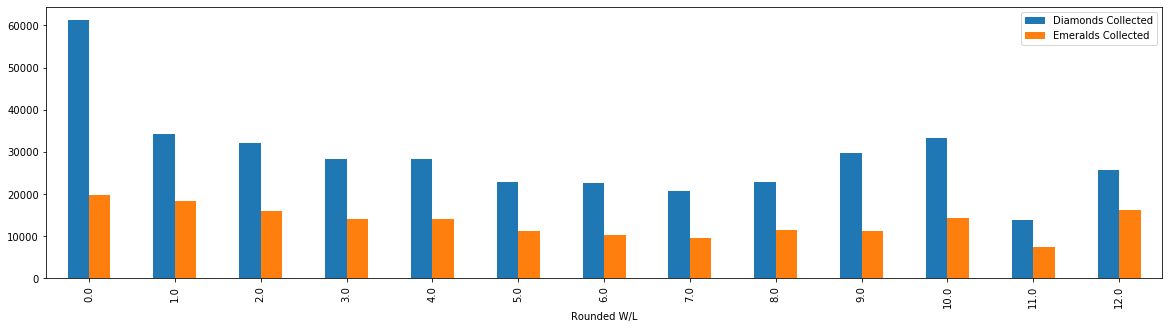

In [38]:
(temp[['Rounded W/L', 'Diamonds Collected', 'Emeralds Collected']].groupby(['Rounded W/L']).mean()).reset_index().plot(kind='bar', x='Rounded W/L', figsize=(20,5))

Ne opazimo nobenega posebnega vzorca. Lahko sklepamo, da količina pobranih surovin ne vpliva na to kako uspešni so igralci.

Oglejmo si še, če je kakšen vzorec pri igralcih, ki večinoma igrajo katerega od igralskih načinov.

In [39]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
temp[(((temp['Quad games'])/(temp['Solo games']+temp['Duo games']+temp['Triple games']+temp['Quad games'])) > 0.5)][['Iron Collected','Gold Collected','Diamonds Collected','Emeralds Collected']].mean(axis = 0)

Iron Collected       1435993.325
Gold Collected        217642.256
Diamonds Collected     22350.043
Emeralds Collected     12247.356
dtype: float64

In [40]:
temp[(((temp['Triple games'])/(temp['Solo games']+temp['Duo games']+temp['Triple games']+temp['Quad games'])) > 0.25)][['Iron Collected','Gold Collected','Diamonds Collected','Emeralds Collected']].mean(axis = 0)

Iron Collected       1506028.042
Gold Collected        248972.516
Diamonds Collected     27391.535
Emeralds Collected     14938.592
dtype: float64

In [41]:
temp[(((temp['Duo games'])/(temp['Solo games']+temp['Duo games']+temp['Triple games']+temp['Quad games'])) > 0.25)][['Iron Collected','Gold Collected','Diamonds Collected','Emeralds Collected']].mean(axis = 0)

Iron Collected       1523944.097
Gold Collected        269087.979
Diamonds Collected     37263.660
Emeralds Collected     17338.560
dtype: float64

In [42]:
temp[(((temp['Solo games'])/(temp['Solo games']+temp['Duo games']+temp['Triple games']+temp['Quad games'])) > 0.25)][['Iron Collected','Gold Collected','Diamonds Collected','Emeralds Collected']].mean(axis = 0)

Iron Collected       1546419.083
Gold Collected        304628.976
Diamonds Collected     51063.595
Emeralds Collected     23621.131
dtype: float64

Ponovno ne opazimo kakšnega posebnefa vzorca, razen tega, a se število diamantov in emeraldov veča, kar je pričakovano, saj se v Quad načinu pojavlja več teh dveh surovin kot v Triple in v Triple več kot v Duo in v Duo več kot v Solo.

# Povezava med W/L v različnih igralski načinih

Zanima nas, če je W/L količnik kot vsota vseh iger povezan z W/L količnikom v posameznem igralskem načinu.

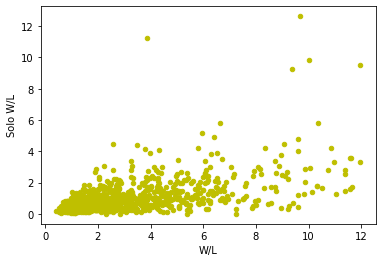

In [43]:
temp = pd.concat([players['W/L'], solo['W/L'], duo['W/L'], triple['W/L'], quad['W/L']], axis=1)
temp.columns = ['W/L', 'Solo W/L', 'Duo W/L', 'Triple W/L', 'Quad W/L']
a = find_para(temp['W/L'])
temp[temp['W/L'] < a[1]].plot(kind='scatter', x='W/L', y='Solo W/L', color='y')

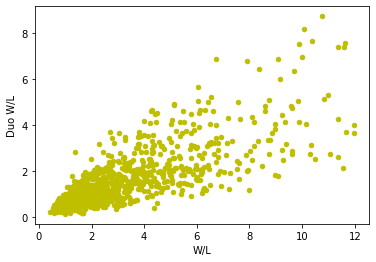

In [44]:
temp[temp['W/L'] < a[1]].plot(kind='scatter', x='W/L', y='Duo W/L', color='y')

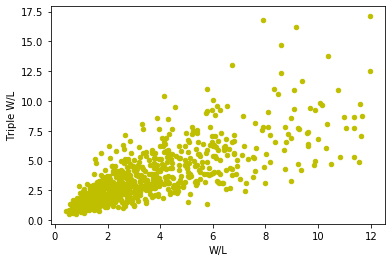

In [45]:
temp[temp['W/L'] < a[1]].plot(kind='scatter', x='W/L', y='Triple W/L', color='y')

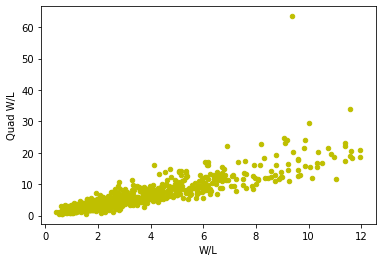

In [46]:
temp[temp['W/L'] < a[1]].plot(kind='scatter', x='W/L', y='Quad W/L', color='y')

Preverimo s pomočjo linearne regresije, če gre kje za linearno odvistnost.

In [47]:
temp.columns = ['A', 'Solo', 'Duo', 'Triple', 'Quad']
lin_reg('Solo ~ A', temp) 

(Intercept   0.064
 A           0.284
 dtype: float64,
 Intercept   0.052
 A           0.007
 dtype: float64)

In [48]:
lin_reg('Duo ~ A', temp) 

(Intercept   -0.050
 A            0.496
 dtype: float64,
 Intercept   0.068
 A           0.009
 dtype: float64)

In [49]:
lin_reg('Triple ~ A', temp) 

(Intercept   0.696
 A           0.813
 dtype: float64,
 Intercept   0.092
 A           0.012
 dtype: float64)

In [50]:
lin_reg('Quad ~ A', temp) 

(Intercept   0.824
 A           1.550
 dtype: float64,
 Intercept   0.199
 A           0.026
 dtype: float64)

Linearna regresija izgleda smiselna (relativne napake so majhne - od $0.006$ do $0.026$). Največji koeficient pa dobimo pri Quad igrah. Kar pomeni, da imajo igralci ne glede na absoluten W/L koeficient največji W/L koeficient pričakovan v Quad načinu. Prav tako pa lahko iz poznanega absolutnega W/L koeficienta sklepamo na ostale in obratno po linearni odvistnosti. 

# Zaključek

Dobili smo odgovore na vse teze, ki smo si jih zastavili. Igralci katerega ranka se največkrat pojavijo na lestvici - MVP+, ali je uspešnosti pri različnih načinih povezana (kot že umenjeno uspešnost ~ W/L) - to smo videli v zgornjem razdelku. Prav tako smo videli, da igralci igrajo večinoma Quad igralski način.

Pogledali smo si pa še veliko več. Kakšna je povezava med FK/D in W/L količnikom v različnih igralskih načinih, gledali smo, če so katere surovine bolj pobirane glede na W/L količnik in tudi to kateremu guildu gre najbolje.

Zanimivo bi bilo pogledati, če obstaja kakšna povezava med različnimi igrami, ki jih server ponuja (ne le bedwars) in uspešnostjo pri teh igrah. 